In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

c:\Users\Penguin\anaconda3\envs\evasion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### FGSM 
- 학습 시 기울기 방향 == 손실이 증가하는 방향
    - 방향성을 알 수 있는 sign() 함수 사용

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mi>x</mi>
  <msub>
    <mi>adv</mi>
  </msub>
  <mo>=</mo>
  <mi>x</mi>
  <mo>+</mo>
  <mi>&#x3B5;</mi>
  <mo>&#x22C5;</mo>
  <mi>sign</mi>
  <mo stretchy="false">(</mo>
  <msub>
    <mo>&#x2207;</mo>
    <mi>x</mi>
  </msub>
  <mi>J</mi>
  <mo stretchy="false">(</mo>
  <mi>&#x3B8;</mi>
  <mo>,</mo>
  <mi>x</mi>
  <mo>,</mo>
  <mi>y</mi>
  <mo stretchy="false">)</mo>
  <mo stretchy="false">)</mo>
</math>

In [28]:
#load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()

# input image preprocess
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

input_image = 'person.jpg'

image = Image.open(input_image).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

image_tensor = preprocess(image).unsqueeze(0).to(device)

output = model(image_tensor)

_, predict = torch.max(output,1)

labels = idx2label[predict.item()]

print(labels)

ballplayer


In [29]:
# fgsm 
def fgsm(epsilon, image, gradient):
    sign_gradient = gradient.sign()
    adversarial_image = image + epsilon * sign_gradient
    return adversarial_image

image_tensor.requires_grad = True

output = model(image_tensor)
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(output, predict)

model.zero_grad()
loss.backward()

gradient = image_tensor.grad.data

# FGSM attack
epsilon = 0.03
adversarial_image = fgsm(epsilon, image_tensor, gradient)

adversarial_output = model(adversarial_image)

_, adversarial_predict = torch.max(adversarial_output,1)

adversarial_labels = idx2label[adversarial_predict.item()]

print(adversarial_labels)

racket


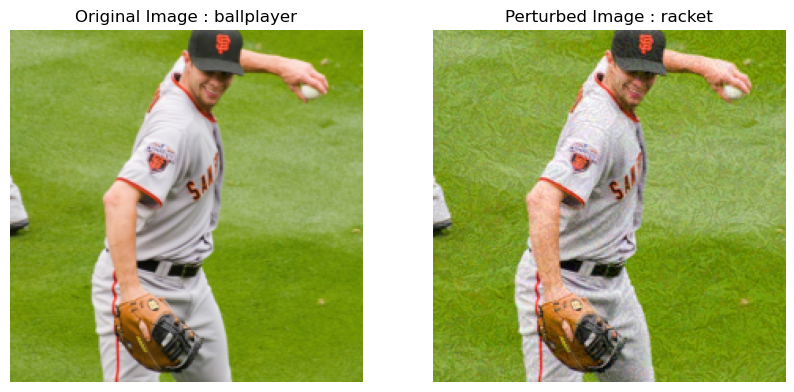

In [30]:
# original
original_image = image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
original_image = np.clip(original_image, 0, 1)

# adversarial
perturbed_image = adversarial_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
perturbed_image = np.clip(perturbed_image, 0, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(original_image)
ax1.set_title(f'Original Image : {labels}')
ax1.axis('off')

ax2.imshow(perturbed_image)
ax2.set_title(f'Perturbed Image : {adversarial_labels}')
ax2.axis('off')

plt.show()